In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ctypes
from time import time

In [2]:
def UnaryCode(n):
    return n + 1

def TruncatedBinaryCode(n, m):
    b = int(np.ceil(np.log(m + 0.) / np.log(2.0)))
    small = (n < (2 ** b - m))
    return (b - 1) * small + b * (1 - small)

def GolombCompress(data, m):
    res = np.sum(UnaryCode(data / m)) + np.sum(TruncatedBinaryCode(data % m, m))
    return res

In [3]:
def Generate():
    filenames = []
    for i in (0.001, 0.004, 0.007, 0.01, 0.04, 0.07, 0.1, 0.5, 0.7):
        data = np.random.geometric(i, 1000000)
        filename = str(int(1000 * i))
        filenames.append(filename)
        with open(filename, 'w') as outputfile:
            for el in data:
                outputfile.write(str(el) + '\n')
    return filenames

In [4]:
def SaveCompCoeffs(filenames):
    compcoeffs = np.zeros((len(filenames), 512), dtype=np.float64)
    thetime = time()
    for i in xrange(len(filenames)):
        data = []
        j = 0
        with open(filenames[i], 'r') as inputfile:
            for line in inputfile:
                j += 1
                if len(line) == 0:
                    break
                n = int(line.strip())
                data.append(n)
                #if (j+1) % 200000 == 0:
                #    print i, j
        print i, "data size is", len(data), time() - thetime
        original_size = len(data) * ctypes.sizeof(ctypes.c_int) * 8
        data = np.array(data)
        for m in xrange(512):
            coded_size = GolombCompress(data, m + 1)
            #if m % 100 == 0:
            #    print m, time() - thetime
            compcoeffs[i][m] = (original_size + 0.) / coded_size   
    return compcoeffs

In [56]:
thetime = time()
filenames = Generate()
print time() - thetime

136.622800827


In [135]:
thetime = time()
compcoeffs = SaveCompCoeffs(filenames)
print time() - thetime

0 data size is 1000000 2.08464479446
1 data size is 1000000 50.6396329403
2 data size is 1000000 98.9426949024
3 data size is 1000000 147.121159792
4 data size is 1000000 195.237345934
5 data size is 1000000 243.329365969
6 data size is 1000000 291.517242908
7 data size is 1000000 339.65118289
8 data size is 1000000 387.710277796
433.805727959


In [174]:
totalcoeffs = np.ravel(np.dot(np.ones((1,9), dtype=np.float64), compcoeffs))
m_opt = np.argmax(totalcoeffs)

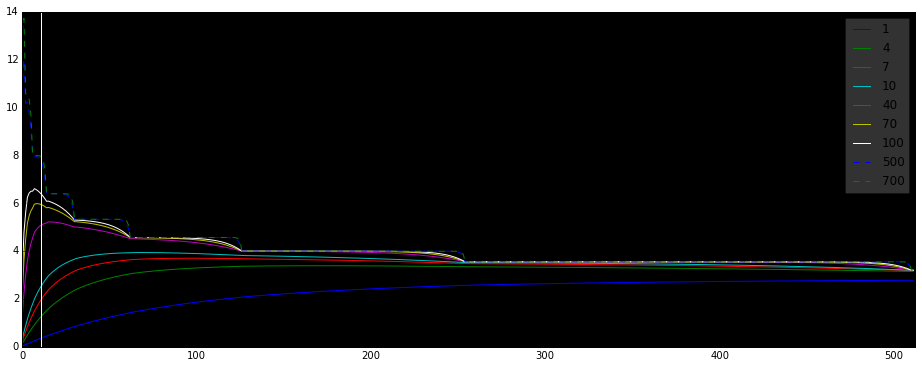

In [200]:
fig = plt.figure(figsize=(16,6))
colors = ('b','g','r','c','m','y','w','b','g')
styles = ('-','-','-','-','-','-','-','--','--')
axes = fig.add_subplot(1, 1, 1, axisbg='black')
for i in xrange(9):
    plt.plot(compcoeffs[i, :], c=colors[i], ls=styles[i], label = filenames[i])
xlim = plt.xlim([0,512])
plt.axvline(x=m_opt, ymin=0, ymax=14, color = 'white')
plt.legend(framealpha=0.2)

In [160]:
def loadLists(filename):
    """Load index from a file, returns dict key = word number
    value = list of (document number, count of word in the document)"""
    index = []
    with open(filename, 'r') as index_file:
        for line in index_file:
            linelist = line.strip().split()[1:]
            current_list = []
            for j in range(1, len(linelist)):
                current_pair = linelist[j].strip().split(':')
                for k in xrange(int(current_pair[1])):
                    current_list.append(int(current_pair[0]))
            index.append(np.sort(np.array(current_list)))
    return np.array(index)

In [17]:
thetime = time()
index = loadLists('index.txt')
print time() - thetime

157.399533987


In [162]:
# compressing
thetime = time()
compressed_index = []
for i in xrange(index.shape[0]):
    if index[i].shape[0] > 0:
        curr_line = np.zeros((index[i].shape[0],), dtype=int)
        curr_line[0] = index[i][0]
        for j in xrange(1, index[i].shape[0]):
            curr_line[j] = index[i][j] - index[i][j-1]
        compressed_index.append(curr_line)
print - thetime + time()

95.5188119411


In [163]:
thetime = time()
full_sizes = np.zeros((len(compressed_index)), dtype=int)
for i in xrange(len(compressed_index)):
    full_sizes[i] =  len(compressed_index[i]) * ctypes.sizeof(ctypes.c_int) * 8
print time() - thetime

1.59688806534


In [ ]:
thetime = time()
comp_sum_coeffs_first = np.zeros((16))
for i in xrange(len(compressed_index)):
    for m in xrange(16):
        coded_size = GolombCompress(compressed_index[i], 2 ** m)
        comp_sum_coeffs_first[m] += coded_size   
print time() - thetime

In [ ]:
plt.plot(comp_sum_coeffs_first)
lim = plt.ylim([0, 0.1 * 10**10])

In [ ]:
m_min_first = 2 ** (np.argmin(comp_sum_coeffs_first) - 1)
m_max_first = 2 ** (np.argmin(comp_sum_coeffs_first) + 1)

In [138]:
thetime = time()
comp_sum_coeffs_second = np.zeros((16))
for i in xrange(len(compressed_index)):
    #if i % 100000 == 0:
    #    print i, time() - thetime
    for m in xrange(16):
        coded_size = GolombCompress(compressed_index[i], m_min_first + ((m_max_first - m_min_first) / 16) * m)
        comp_sum_coeffs_second[m] += coded_size   
print time() - thetime

1339.55896091


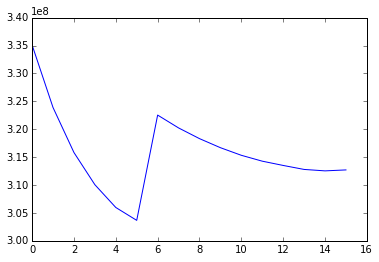

In [139]:
plt.plot(comp_sum_coeffs_second)
#lim = plt.ylim([0, 0.1 * 10**10])

In [140]:
m_min_second = m_min_first + ((m_max_first - m_min_first) / 16) * (np.argmin(comp_sum_coeffs_second) - 1)
m_max_second = m_min_first + ((m_max_first - m_min_first) / 16) * (np.argmin(comp_sum_coeffs_second) + 1)

In [141]:
thetime = time()
comp_sum_coeffs_third = np.zeros((16))
for i in xrange(len(compressed_index)):
    #if i % 100000 == 0:
    #    print i, time() - thetime
    for m in xrange(16):
        coded_size = GolombCompress(compressed_index[i], m_min_second + ((m_max_second - m_min_second) / 16) * m)
        comp_sum_coeffs_third[m] += coded_size   
print time() - thetime

1332.95737982


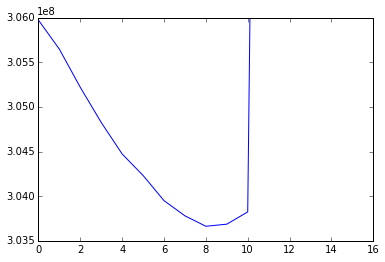

In [142]:
plt.plot(comp_sum_coeffs_third)
lim = plt.ylim([3.035 * 10 ** 8, 3.06 * 10**8])

In [155]:
m_min_third = m_min_second + ((m_max_second - m_min_second) / 16) * (np.argmin(comp_sum_coeffs_third) - 2)
m_max_third = m_min_second + ((m_max_second - m_min_second) / 16) * (np.argmin(comp_sum_coeffs_third) + 2)

In [157]:
thetime = time()
comp_sum_coeffs_last = np.zeros((m_max_third - m_min_third + 1))
for i in xrange(len(compressed_index)):
    #if i % 100000 == 0:
    #    print i, time() - thetime
    for m in xrange(m_min_third, m_max_third + 1):
        coded_size = GolombCompress(compressed_index[i], m)
        comp_sum_coeffs_last[m - m_max_third] += coded_size   
print time() - thetime

950.275660038


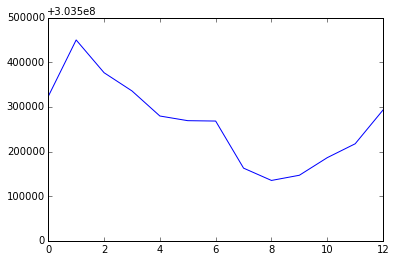

In [158]:
plt.plot(comp_sum_coeffs_last)
lim = plt.ylim([3.035 * 10**8, 3.04 * 10**8])

In [ ]:
opt_big_index_m = m_min_third + np.argmin(comp_sum_coeffs_last)

In [147]:
print 'opt m ', opt_big_index_m

opt m  250


In [118]:
l = np.argmax(full_sizes)
print 'max list: ', l, compressed_index[l].shape[0]

 max list:  175968 435178


In [78]:
l_comp_coeffs = np.zeros((512))
for m in xrange(512):
    l_comp_coeffs[m] = GolombCompress(compressed_index[l], m + 1)
m_opt = np.argmin(l_comp_coeffs) + 1
print 'optimal m: ', m_opt

optimal m:  1


In [79]:
p_t = (compressed_index[l].shape[0] + 0.) / (compressed_index[l].shape[0] + np.sum(compressed_index[l]))
print 'theoretical p: ', p_t

theoretical p:  0.94409962143


In [80]:
def Vurhis(p):
    for m in xrange(512):
        if p ** (m + 1) + p ** (m + 2) <= 1 and 1 < p ** (m + 1) + p ** m:
            return m+1#, p, p ** (m + 1) + p ** (m + 2),  p ** (m + 1) + p ** m
    return 512

In [83]:
print 'theoretical m: ', Vurhis(p_t)

 theoretical m:  12
